In [3]:
from music21 import *

# Function to analyze key changes in the score
# Parameters:
# - score: A music21 stream object representing the musical score.
# Returns:
# - loc: A set of measure numbers where key changes occur.
# Example usage:
#   loc = anaKey(score)
def anaKey(score):
    # Counts number of measures in the score
    num_measures = sum(1 for _ in score.parts[0].getElementsByClass('Measure'))

    # if less than 4 measures, throw error
    if num_measures < 4:
        raise ValueError("The music is too short! It must be at least 4 measures long.")

    # prevKey tracks the key of the previous bar. Starts with the key of the 1st four measures
    prevKey = score.measures(1,4).analyze('key')
    loc = set()

    # prevKC tracks where the last key change occured
    prevKC = 1

    # Recursively analyzes the key of each measure based on itself and the 3 measures before it
    for n in range(2, num_measures-3):
        # the 4-bar segment
        seg = score.measures(n, n+3)

        # analyzes the segment
        key = seg.analyze('key')

        # if the key is different, record the measure of the key change
        if key != prevKey:
            for m in range(prevKC, n+3):
                cur = score.measure(m)
                mKey = cur.analyze('key')

                # if mKey != key, that means the music has not completed a key change
                if mKey == key:
                    print(f"At measure {m} prevKey: {prevKey} curKey: {key}")
                    first_note_or_rest = cur.flat.notes.stream().first() or cur.flat.rests.stream().first()
                    first_note_or_rest.lyric = "KEY CHANGE"
                    loc.add(m) # records location

                    # updates prevKey to current key, last key change location to current measure
                    prevKey = key
                    prevKC = m
                    break
    
    return loc # returns list of location where key has changed

# Function to condense a score by combining notes into chords
# Parameters:
# - score: A music21 stream object representing the musical score.
# Returns:
# - xx: A condensed version of the score where all parts are combined into a single chordal structure.
# Example usage:
#   condensed_score = condense(score)
def condense(score):    
    xx = score.chordify()
    for c in xx.recurse().getElementsByClass(chord.Chord):
        c.closedPosition(forceOctave=4, inPlace=True)
    return xx

# Function to move the highest note of a chord down by an octave
# Parameters:
# - c: A music21 chord object.
# Returns:
# - new_chord: The chord with the highest note transposed down by an octave.
# Example usage:
#   new_chord = moveChord(chord_obj)
def moveChord(c: chord.Chord) -> chord.Chord:
    # check if c is an empty chord
    if not c.pitches:
        return c
    
    sorted_notes = sorted(c.pitches) # sorts notes from low pitch to high
    c = chord.Chord(sorted_notes) 
    highest_pitch = c.pitches[-1]
    transposed_highest = highest_pitch.transpose(interval.Interval("-P8")) # takes highest pitch down an octave
    new_pitches = list(c.pitches[:-1]) + [transposed_highest]
    new_chord = chord.Chord(new_pitches)
    return new_chord

# Function to modify a chord if it contains a major or minor 2nd or 7th interval
# Parameters:
# - ch: A music21 chord object.
# Returns:
# - ch: The chord after modification.
# Example usage:
#   modified_chord = min7(chord_obj)
def min7(ch: chord.Chord) -> chord.Chord:
    intervals = {}
    pitches = sorted(ch.pitches)
    r = 0
    y = 0

    # check if any interval between the pitches is major/minor 2nd
    for i in range(len(pitches)):
        for j in range(i + 1, len(pitches)):
            inter = interval.Interval(pitches[i], pitches[j])
            if inter.name == "M2" or inter.name == "m2":
                intervals[f"{pitches[i].nameWithOctave} to {pitches[j].nameWithOctave}"] = inter.name
                r = j
                y = 2
            elif inter.name == "M7" or inter.name == "m7":
                intervals[f"{pitches[i].nameWithOctave} to {pitches[j].nameWithOctave}"] = inter.name
                r = i
                y = 7
    if len(intervals) == 1:
        if y == 2:
            for k in range(len(pitches)-r): # modify the chord so that root notes is the higher note of the 2nd
                ch = moveChord(ch)
        if y == 7:
            for k in range(len(pitches)-r): # modify the chord so that root notes is the lower note of the 7th
                ch = moveChord(ch)
        ch = ch.transpose("P8")
    
    return ch

# Function to adjust a chord's range so that the lowest pitch falls between E2 and E3
# Parameters:
# - ch: A music21 chord object.
# Returns:
# - ch: The chord transposed to the target range if necessary.
# Example usage:
#   adjusted_chord = adjust_chord_range(chord_obj)
def adjust_chord_range(ch):
    if not ch.pitches:
        return ch
    lower_bound = pitch.Pitch("E2")
    upper_bound = pitch.Pitch("E3")

    lowest_pitch = min(ch.pitches)

    if lowest_pitch < lower_bound:
        ch = ch.transpose("P8")
        adjust_chord_range(ch) # recurse until low note is in range
    elif lowest_pitch > upper_bound:
        ch = ch.transpose("-P8")
        adjust_chord_range(ch) # recurse until low note is in range

    return ch

# Function to convert a set of pitches to a Roman numeral based on the current key
# Parameters:
# - set: A set of pitches (music21.pitch).
# - curKey: The current key (music21.key.Key).
# Returns:
# - RomanNumeral: A Roman numeral object representing the chord.
# Example usage:
#   roman_numeral = notesToRoman(pitches_set, curKey)
def notesToRoman(set:pitch, curKey):
    ch = chord.Chord(list(set))

    # try to adjust the chord so that it is in common form
    if roman.romanNumeralFromChord(ch, curKey).functionalityScore == 0 or roman.romanNumeralFromChord(ch, curKey.parallel).functionalityScore == 0:
        x = 1
        chh = moveChord(ch)
        while x < len(ch.pitches):
            if roman.romanNumeralFromChord(chh, curKey).functionalityScore > 0 or roman.romanNumeralFromChord(ch, curKey.parallel).functionalityScore > 0:
                ch = chh # the chord is successfully adjusted
                x = 100000000
            else: # none of the chord's possible shapes are common
                chh = moveChord(chh)
                x += 1
        if x < 1000:
            ch = min7(ch) # maybe the chord has a 2nd/7th interval
                
    return roman.romanNumeralFromChord(adjust_chord_range(ch), curKey)  

def getDiv(measure):
    """
    Calculate a divisor based on the time signature of a measure.

    Parameters:
    measure (music21.stream.Measure): The measure from which to retrieve the time signature.

    Returns:
    float: A divisor based on the time signature, calculated as follows:
        - If the time signature denominator is 4, returns 1.
        - If the numerator of the time signature is a divisor of 3, returns 12.0 divided by the denominator.
        - Otherwise, returns 4.0 divided by the denominator.
    """
    
    # Check if the measure contains a time signature
    if any(isinstance(el, meter.TimeSignature) for el in measure.notesAndRests): 
        ts = measure.timeSignature  # Get the time signature of the measure
        
        # Check if the denominator of the time signature is 4
        if ts.denominator == 4:
            return 1  # Return 1 if denominator is 4
        
        # Check if the numerator is a divisor of 3
        elif ts.numerator % 3 == 0:
            return 12.0 / ts.denominator  # Return 12.0 divided by the denominator
        
        else:
            return 4.0 / ts.denominator  # Return 4.0 divided by the denominator
    
    else:
        return 1  # Return 1 if there is no time signature in the measure

# Function to analyze harmony and key changes, inserting Roman numeral annotations
# Parameters:
# - score: The original music21 stream object representing the score.
# - condensed: A condensed version of the score (output of condense function).
# - loc: A set of measure numbers where key changes occur (output of anaKey function).
# Returns:
# - outPart: A music21 stream object with Roman numeral annotations and key changes.
# Example usage:
#   analyzed_part = anaHarm(score, condensed_score, key_change_locations)
def anaHarm(score, condensed, loc): 
    outPart = condensed.template(fillWithRests=False)
    curKey = score.analyze('key')

    inMeasures = list(condensed[stream.Measure])
    outMeasures = list(outPart[stream.Measure])

    div = getDiv(score.measure(1)) # accounts for different meters

    for i in range(sum(1 for _ in score.parts[0].getElementsByClass('Measure'))):
        if any(isinstance(el, meter.TimeSignature) for el in score.measure(1).notesAndRests): # in case of meter changes
            div = getDiv(score.measure(i))
        if i+1 in loc: # we are at a key change
            curKey = score.measure(i+1).analyze('key')
        inMeasure = inMeasures[i]
        outMeasure = outMeasures[i]
        dur = inMeasure.duration.quarterLength

        for beatStart in range(int(dur)):
            combined_pitches = set()  # List of pitches for each beat
            beatNotes = inMeasure.getElementsByOffset(beatStart,
                                                        beatStart + div,
                                                        includeEndBoundary=False
                                                        ).getElementsByClass(chord.Chord)

            # Gather pitches from beatNotes
            for elem in beatNotes:
                if isinstance(elem, chord.Chord) and (elem.offset) == int(elem.offset):
                    combined_pitches.update(elem.pitches)

            if not combined_pitches:
                continue  # Skip if there are no pitches

            # Create a chord with the combined pitches
            beatChord = chord.Chord(combined_pitches)

            # Set the offset and duration of the chord
            beatChord.offset = beatStart  # Set the offset to the current beat
            beatChord.quarterLength = div  # Set duration to 1 quarter note (or other depending on meter)

            # Analyze the Roman numeral for this beat
            beatRN = notesToRoman(combined_pitches, curKey)  # Analyzes harmony of pitches in each beat
            beatChord.lyric = beatRN.figure  # Adds the Roman numeral to the sheet

            # Insert the actual chord and the Roman numeral into the measure
            outMeasure.insert(beatStart, beatChord)  # Insert the actual chord

        
    # annotates key change locations    
    for m in loc:
        mod = expressions.TextExpression("MODULATION")
        k = score.measure(m).analyze('key')
        newKey = expressions.TextExpression("new key: " + str(k))
        outPart.measure(m-1).append(newKey)
    
    return outPart

# Function to run the full analysis on a score, combining key change and harmonic analysis
# Parameters:
# - score: A music21 stream object representing the musical score.
# Returns:
# - outPart: A music21 stream object with key change and harmonic analysis annotations.
# Example usage:
#   analyzed_score = analyze(score)
def analyze(score):
    loc = anaKey(score) # get locations of key changes
    xx = condense(score) # simplifies the input score
    outPart = anaHarm(score, xx, loc) # analyzes harmony of simplified input, produces output
    return outPart

At measure 5 prevKey: a minor curKey: e minor
At measure 9 prevKey: e minor curKey: a minor
At measure 13 prevKey: a minor curKey: e minor
At measure 18 prevKey: e minor curKey: c# minor
At measure 22 prevKey: c# minor curKey: C major
At measure 26 prevKey: C major curKey: G major
At measure 27 prevKey: G major curKey: d minor
At measure 30 prevKey: d minor curKey: e minor
At measure 35 prevKey: e minor curKey: C major
At measure 36 prevKey: C major curKey: d minor
At measure 38 prevKey: d minor curKey: F major
At measure 50 prevKey: F major curKey: a minor
At measure 54 prevKey: a minor curKey: e minor
At measure 55 prevKey: e minor curKey: E major
At measure 74 prevKey: E major curKey: B- major
At measure 77 prevKey: B- major curKey: d minor
At measure 78 prevKey: d minor curKey: a minor


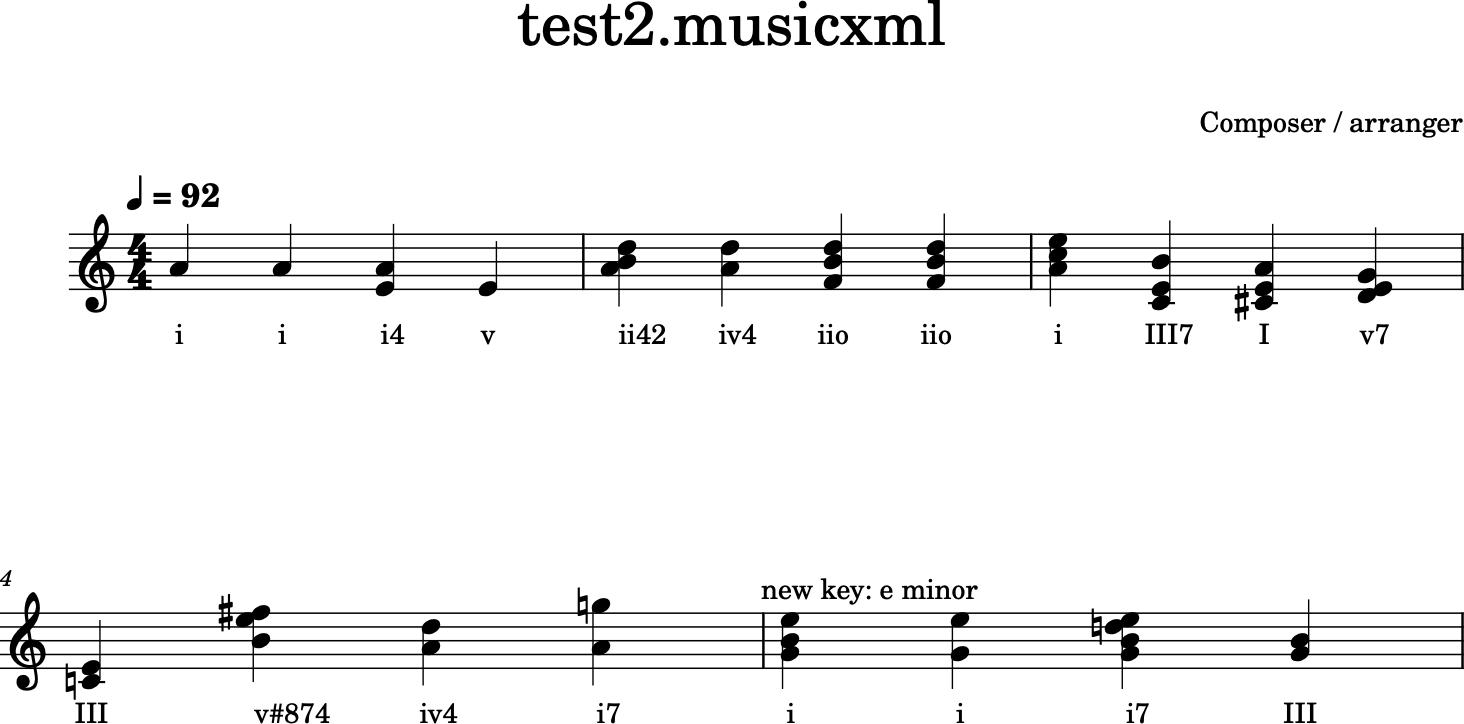

In [2]:
test = converter.parse("/Users/tao-taohe/Desktop/harmoniSync/algorithm/data/test2.musicxml")

get = analyze(test)
get.show()

In [4]:
def rootVal(root):
    E = note.Note('E2')
    inter = interval.Interval(E, root)
    n = inter.semitones % 12
    f = n
    if n > 9:
        f -= 10
    elif n > 4:
        f -= 5
    return f

def findPitch(empty, f, chordPitches):
    empty = empty.transpose(f)
    i = 0
    if len(chordPitches) == 1:
        print(chordPitches[0])
        #print(lone.name)
        #fifth = lone.transpose(7)
        #print(fifth.name)
        #chordPitches.append(fifth)

    # Check if the input_note matches any pitch in the chordPitches
    while i < 50:
        for j in range(len(chordPitches)):
            if (interval.Interval(empty, chordPitches[j]).semitones) % 12 == 0:
                #print(interval.Interval(empty, chordPitches[j]))
                #print("noooo")
                return empty  # Return the matched note
            else:
                print("")
            
        print(empty.pitch)
        empty = empty.transpose(1)  # Transpose up 1 half-step
        i += 1

def voicing(chorD):
    voiced = []
    root = chorD.root()
    f = rootVal(root)
    chordPitches = chorD.pitches

    one = findPitch(note.Note('E3'), f, chordPitches)
    print("String 6 (E3):", one.name)
    voiced.append(one)

    two = findPitch(note.Note('A3'), f, chordPitches)
    print("String 5 (A3):", two.name)
    voiced.append(two)

    three = findPitch(note.Note('D4'), f, chordPitches)
    print("String 4 (D4):", three.name)
    voiced.append(three)

    four = findPitch(note.Note('G4'), f, chordPitches)
    print("String 3 (G4):", four.name)
    voiced.append(four)

    five = findPitch(note.Note('B4'), f, chordPitches)
    print("String 2 (B4):", five.name)
    voiced.append(five)

    six = findPitch(note.Note('E5'), f, chordPitches)
    print("String 1 (E5):", six.name)
    voiced.append(six)

    newChord = chord.Chord(voiced)

    return newChord

def guitarScore(outPart):
    for i in range(sum(1 for _ in outPart.getElementsByClass('Measure'))):
        measures = outPart.getElementsByClass('Measure')
        
        for measure in measures:
            for chord_item in measure.getElementsByClass(chord.Chord):
                newChord = voicing(chord_item)
                newChord.lyric = chord_item.lyric
                measure.replace(chord_item, newChord)

    return outPart

In [6]:
getForever = get
one = getForever.measure(1).getElementsByOffset(0,
                        1,
                        includeEndBoundary=False
                        ).getElementsByClass(chord.Chord)
one[0].root()
a = rootVal(one[0].root())
chordPitches = one[0].pitches

empty = note.Note('E').transpose(0)
empty

while True:
    if (interval.Interval(empty, chordPitches[0]).semitones) % 12 == 0:
        #print(interval.Interval(empty, chordPitches[j]))
        #print("noooo")
        print("match")
        break
    else:
        print(empty.name)
        empty = empty.transpose(1)

print(empty.name)

print("done")
empty

E
F
F#
G
G#
match
A
done


<music21.note.Note A>

In [11]:
getForever = get

guitar = guitarScore(getForever.measures(1,4))
guitar.show()

ChordException: no pitches in chord <music21.chord.Chord object at 0x12f20a370>

In [4]:
one = get.measure(1).getElementsByOffset(0,
                        1,
                        includeEndBoundary=False
                        ).getElementsByClass(chord.Chord)
one[0].pitches[0]

<music21.pitch.Pitch A4>

In [ ]:
guitar = guitarScore(get)
guitar.write('musicxml', fp='/Users/tao-taohe/Desktop/harmoniSync/algorithm/harmAnalyze/mosesG.musicxml')

PosixPath('/Users/tao-taohe/Desktop/harmoniSync/algorithm/harmAnalyze/mosesG.musicxml')

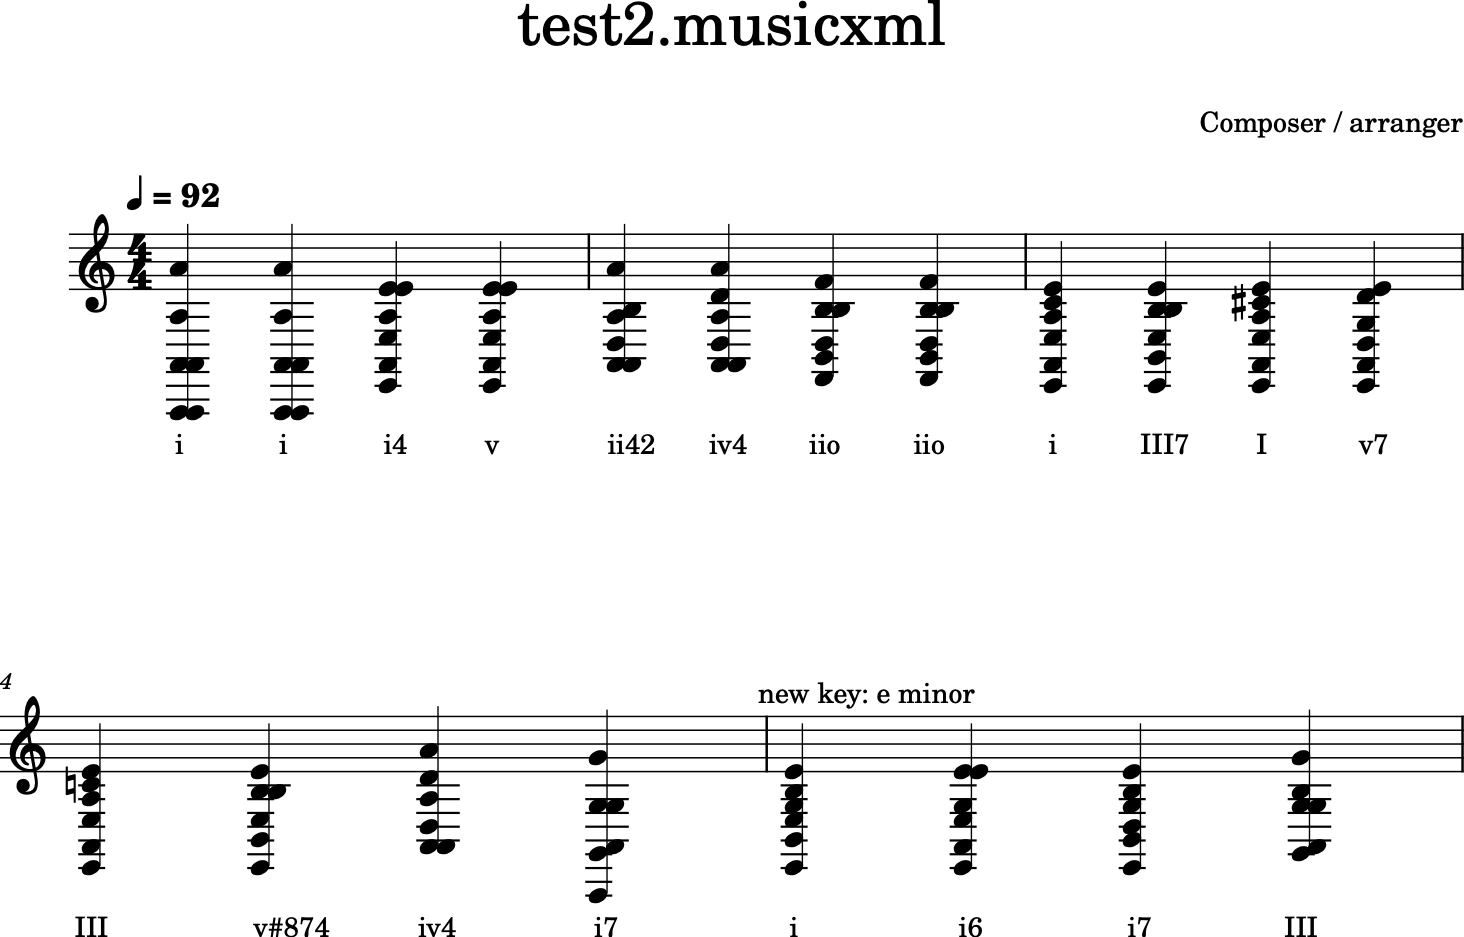

In [43]:
guitar.show()

In [ ]:
# Save to MusicXML format
get.write('musicxml', fp='/Users/tao-taohe/Desktop/harmoniSync/algorithm/harmAnalyze/moses.musicxml')


PosixPath('/Users/tao-taohe/Desktop/harmoniSync/algorithm/harmAnalyze/moses.musicxml')